# Birth Rates of Humpback and Fin Whales in the Gulf of St. Lawrence

In this study, we'll be assessing how birth rate is changing for Humpback and Fin Whales in the Gulf of St. Lawrence. Birth rate is one measure that tells us how species are changing over time, which helps people decide which species to focus our conservation energies towards. We'll be comparing the average birth rate in 2005-2016 and compare it with 1980-2004.

### Import statement

In [71]:
from IPython.core.debugger import set_trace
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

import os
import pandas as pd
import pickle
import pymc3 as pm
os.environ["MKL_THREADING_LAYER"] = "GNU"

import re
from scipy import stats
import seaborn as sns
import tempfile
import theano.tensor as tt

# local
from lib.prior_generation import min_age_prior

## Models

### Complete Pooling Model

$$
    \begin{equation}
        \begin{aligned}
        \text{age}_{i,t+1} &= \text{age}_{i,t} + 1 & \text{age increases by one every year} \\
        \text{alive}_{i,t+1} &=
        \begin{cases}
          1, & \text{if age}_{i,t} = 0 \\
          0, & \text{if alive}_{i,t} = 0 \\
          Bernoulli(s_t) & \text{if alive}_{i,t} = 1 \\
        \end{cases} \\
        s_t &\sim Beta(\alpha_{s_t}=1, \beta_{s_t}=1) & \text{survival parameter} \\
        \text{repro_active}_{i,t+1} &=
        \begin{cases}
          0, & \text{if alive}_{i, t+1}=0 \text{ or age}_{i,t+1} < 9 \\
          1 & \text{otherwise}
        \end{cases} \\
        \text{birth}_{i,t+1} &=
        \begin{cases}
          0, & \text{if birth}_{t,i} = 1 \text{ or } \text{repro_active}_{i,t+1} = 0 \\
          Bernoulli(b_t) & \text{otherwise}
        \end{cases} \\
        b_t &\sim Beta(\alpha_{b_t}=1, \beta_{b_t}=1) & \text{birth parameter} \\
        \text{count}_{i,t+1} &=
        \begin{cases}
            0, & \text{if alive}_{i,t+1} = 0 \\
            1 + \text{birth}_{i,t+1} & \text{if} Bernoulli(d_t) = 1
        \end{cases} \\
        d_t &\sim Beta(\alpha_{d_t}=1, \beta_{d_t}=1) & \text{detection parameter} \\
        \end{aligned}
    \end{equation}
$$

### Partial Pooling Model

$$
    \begin{equation}
        \begin{aligned}
        \text{age}_{i,t+1} &= \text{age}_{i,t} + 1 & \text{age increases by one every year} \\
        \text{alive}_{i,t+1} &=
        \begin{cases}
          1, & \text{if age}_{i,t} = 0 \\
          0, & \text{if alive}_{i,t} = 0 \\
          Bernoulli(p_i) & \text{if alive}_{i,t} = 1 \\
        \end{cases} \\
        p_i &\sim Beta(\alpha_{p}, \beta_{p}) & \text{survival parameter} \\
        \alpha_{p} &\sim Exponential(\lambda=0.1) \\
        \beta_{p} &\sim Exponential(\lambda=0.1) \\
        \text{repro_active}_{i,t+1} &=
        \begin{cases}
          0, & \text{if alive}_{i, t+1}=0 \text{ or age}_{i,t+1} < 9 \\
          1 & \text{otherwise}
        \end{cases} \\
        \text{birth}_{i,t+1} &=
        \begin{cases}
          0, & \text{if birth}_{t,i} = 1 \text{ or } \text{alive}_{i,t+1}=0 \\
          Bernoulli(b_i) & \text{otherwise}
        \end{cases} \\
        b_i &\sim Beta(\alpha_{b}, \beta_{b}) & \text{birth parameter} \\
        \alpha_{b} &\sim Exponential(\lambda=0.1) \\
        \beta_{b} &\sim Exponential(\lambda=0.1) \\
        \text{count}_{i,t+1} &=
        \begin{cases}
            0, & \text{if alive}_{i,t+1} = 0 \\
            1 + \text{birth}_{i,t+1} & \text{if} Bernoulli(c_i) = 1
        \end{cases} \\
        c_i &\sim Beta(\alpha_{c}, \beta_{c}) & \text{detection parameter} \\
        \alpha_{c} &\sim Exponential(\lambda=0.1) \\
        \beta_{c} &\sim Exponential(\lambda=0.1) \\
        \end{aligned}
    \end{equation}
$$

### Time-Varying Partially Pooled Model

Below we display the causal diagram. Each node represents a variable in the format of $V_{a,b}$, where $a$ stands for the individual, $b$ is the year, and $V$ is the variable. Individuals $i$ and $j$ are represented in this graph. The white nodes are nodes that are shared amongst individuals.

![Time-Varying Partially-Pooled Model](../img/time-varying-partially-pooled.png)

In terms of probability distributions, here's the specification of the model:

$$
    \begin{equation}
        \begin{aligned}
        \text{age}_{i,t+1} &= \text{age}_{i,t} + 1 & \text{age increases by one every year} \\
        \text{alive}_{i,t+1} &=
        \begin{cases}
          1, & \text{if age}_{i,t} = 0 \\
          0, & \text{if alive}_{i,t} = 0 \\
          Bernoulli(p_{i,t+1}) & \text{if alive}_{i,t} = 1 \\
        \end{cases} \\
        p_{i,t+1} &\sim Beta(\alpha_{p_{i,t+1}}, \beta_{p_{i,t+1}}) & \text{survival parameter} \\
        \alpha_{p_{i,t+1}} &\sim Posterior(\alpha_{p_{i,t}}) \\
        \beta_{p_{i,t+1}} &\sim Posterior(\beta_{p_{i,t}}) \\
        \alpha_{p_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \beta_{p_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \text{repro_active}_{i,t+1} &=
        \begin{cases}
          0, & \text{if alive}_{i, t+1}=0 \text{ or age}_{i,t+1} < 9 \\
          1 & \text{otherwise}
        \end{cases} \\
        \text{birth}_{i,t+1} &=
        \begin{cases}
          0, & \text{if birth}_{t,i} = 1 \text{ or } \text{alive}_{i,t+1}=0 \\
          Bernoulli(b_{i,t}) & \text{otherwise}
        \end{cases} \\
        b_i &\sim Beta(\alpha_{b}, \beta_{b}) & \text{birth parameter} \\
        \alpha_{b_{i,t+1}} &\sim Posterior(\alpha_{b_{i,t}}) \\
        \beta_{b_{i,t+1}} &\sim Posterior(\beta_{b_{i,t}}) \\
        \alpha_{b_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \beta_{b_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \text{count}_{i,t+1} &=
        \begin{cases}
            0, & \text{if alive}_{i,t+1} = 0 \\
            1 + \text{birth}_{i,t+1} & \text{if} Bernoulli(c_i) = 1
        \end{cases} \\
        c_i &\sim Beta(\alpha_{c_{i,t}}, \beta_{c_{i,t}}) & \text{detection parameter} \\
        \alpha_{c_{i,t+1}} &\sim Posterior(\alpha_{c_{i,t}}) \\
        \beta_{c_{i,t+1}} &\sim Posterior(\beta_{c_{i,t}}) \\
        \alpha_{c_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \beta_{c_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \end{aligned}
    \end{equation}
$$

## Data Cleaning

In [72]:
calving_data = pd.read_excel('./data/females_calving_2016 up to date.xlsx')
calving_data

,MICS,HWC numbers,80,81,82,83,84,85,86,87,...,08,09,10,11,12,13,14,15,16,Unnamed: 39
0,H002,3229,1.0,NaN,NaN,1.0,1,NaN,NaN,1.0,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,NaN
1,H004,1422,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H008,1417,NaN,NaN,2.0,1.0,1,2.0,NaN,NaN,...,1.0,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,2.000000,NaN
3,H009,1419,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,2.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,NaN
4,H035,2088,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,H042,1451,NaN,NaN,NaN,1.0,1,NaN,NaN,1.0,...,2.0,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,2.000000,NaN
6,H044,1424,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,H065,7002,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,H067,7014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,H102,NaN,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,...,1.0,NaN,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,NaN


### Only look at those rows with ids

In [73]:
with_ids = calving_data[calving_data['MICS'].notnull() | calving_data['HWC numbers'].notnull()]
# generate our own id for each whale, which is a composite of MICS and HWC numbers.
with_ids.index = with_ids['MICS'].astype(str) + '-' + with_ids['HWC numbers'].astype(str)
with_ids

,MICS,HWC numbers,80,81,82,83,84,85,86,87,...,08,09,10,11,12,13,14,15,16,Unnamed: 39
H002-3229,H002,3229,1.0,NaN,NaN,1.0,1,NaN,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN
H004-1422,H004,1422,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H008-1417,H008,1417,NaN,NaN,2.0,1.0,1,2.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,2.0,NaN
H009-1419,H009,1419,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN
H035-2088,H035,2088,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H042-1451,H042,1451,NaN,NaN,NaN,1.0,1,NaN,NaN,1.0,...,2.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,2.0,NaN
H044-1424,H044,1424,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H065-7002,H065,7002,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H067-7014,H067,7014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H102-nan,H102,NaN,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,...,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN


In [74]:
def yearify(x):
    """
        Convert strings to years.
        
        The data only has years showing last two digits. We want to convert 
        them into a four-digit number.
        
        Parameters:
        
            x: string, two digits
            
        Returns:
        
            integer year with four digits.
    """
    _x = int(x)
    if _x >= 80:
        return 1900 + _x
    else:
        return 2000 + _x

### Make columns four-digit years

This will enable us to add 1 to the year to get the next year. Previously this doesn't necessarily lead to the correct result. For example 1999 was represented as 99. 99 + 1 = 100 instead of 00 (which stood for 2000).

In [75]:
# Remove some columns we don't care about
unsorted_years_xx = list(set(with_ids.columns) - set(['MICS', 'HWC numbers', 'Unnamed: 39']))

# Get the dataframe where columns are of interest
with_ids_unsorted_years_xx = with_ids[unsorted_years_xx]

# Convert each column into a stringified four-digit year
unsorted_years_xxxx = list(
        map(
            lambda x: str(x),
            map(
                yearify,
                with_ids_unsorted_years_xx.columns
            )
        )
    )

with_ids_unsorted_years_xx.columns = unsorted_years_xxxx
with_ids_unsorted_years_xx

,2005,2011,2012,2016,2003,2014,2008,2004,2002,2007,...,1992,1993,1994,1996,1995,1997,1998,1999,2013,2009
H002-3229,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,...,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
H004-1422,2.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,2.0,1.0,1.0,NaN,1.0
H008-1417,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,NaN,1.0,...,1.0,1.0,2.0,NaN,NaN,2.0,NaN,2.0,NaN,1.0
H009-1419,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,...,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
H035-2088,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H042-1451,2.0,1.0,NaN,2.0,1.0,1.0,2.0,NaN,1.0,1.0,...,1.0,2.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,1.0
H044-1424,1.0,NaN,NaN,NaN,1.0,NaN,1.0,2.0,NaN,2.0,...,1.0,1.0,1.0,1.0,NaN,1.0,2.0,1.0,NaN,NaN
H065-7002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H067-7014,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN
H102-nan,2.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cleaned Matrix

In [76]:
with_ids_sorted_years_xxxx = with_ids_unsorted_years_xx[
    sorted(
        unsorted_years_xxxx
    )
]
with_ids_sorted_years_xxxx

cleaned_matrix = with_ids_sorted_years_xxxx.fillna(value=0).astype(int)
cleaned_matrix


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
H002-3229,1,0,0,1,1,0,0,1,1,2,...,2,1,1,1,1,1,1,1,2,1
H004-1422,0,0,1,2,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
H008-1417,0,0,2,1,1,2,0,0,1,2,...,1,1,1,1,1,1,0,1,1,2
H009-1419,0,0,1,0,0,0,0,1,1,1,...,1,2,1,1,1,1,1,1,2,1
H035-2088,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
H042-1451,0,0,0,1,1,0,0,1,2,1,...,1,2,1,1,1,0,1,1,1,2
H044-1424,0,0,1,1,0,1,1,1,1,1,...,2,1,0,2,0,0,0,0,0,0
H065-7002,0,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
H067-7014,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
H102-nan,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,1,1,0,1,1,1


### Heatmap

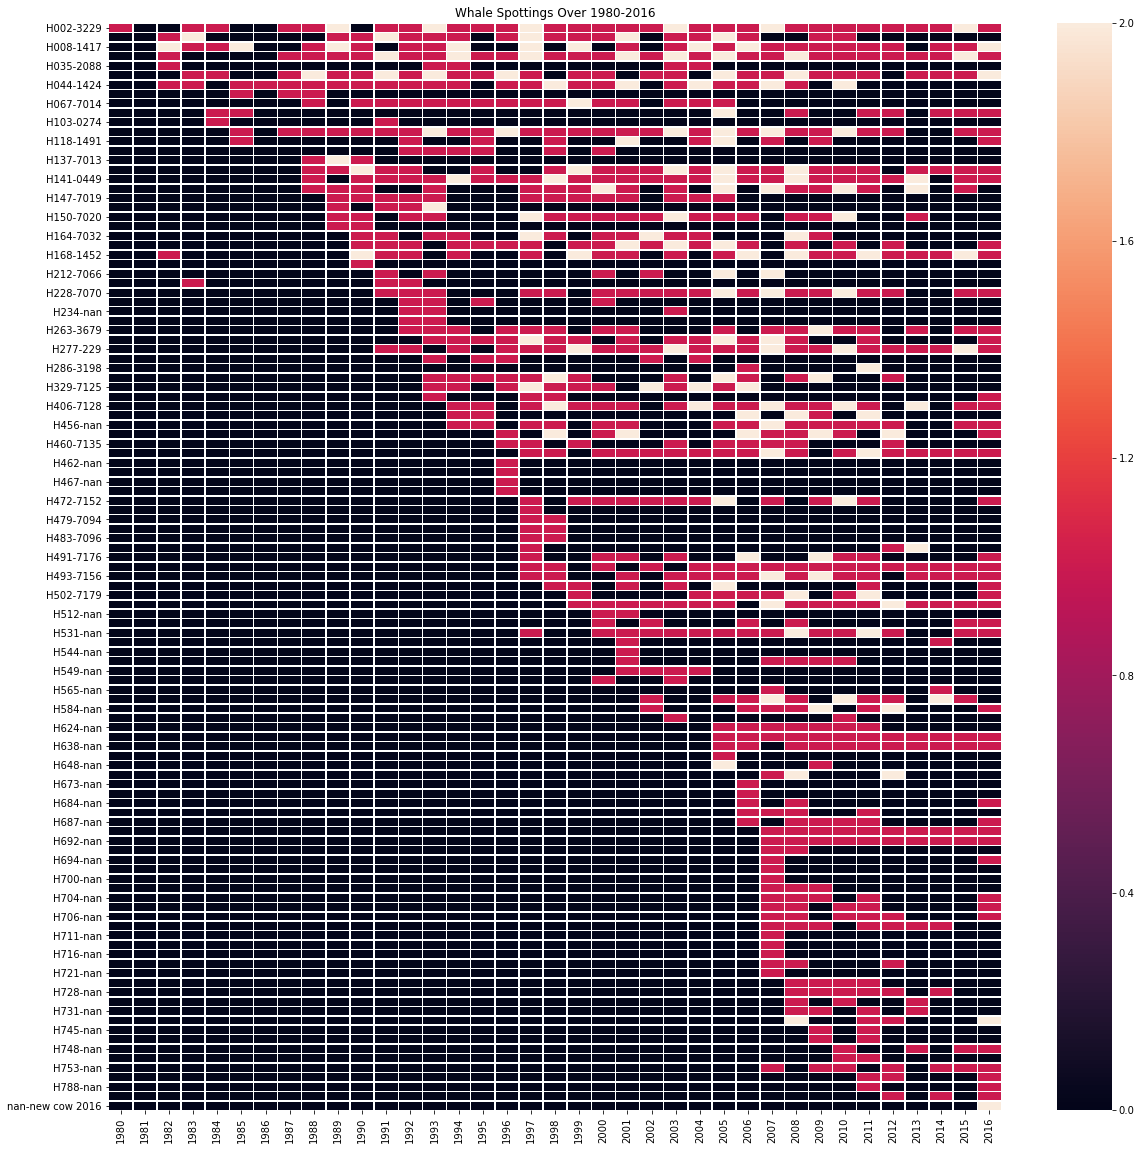

In [77]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.set_title('Whale Spottings Over 1980-2016')
sns.heatmap(cleaned_matrix, ax=ax, linewidths=0.5)

In [78]:
(cleaned_matrix['2005'] == 2).sum() / (cleaned_matrix['2005'] > 0).sum()

0.4146341463414634

## Modeling

$$
    \begin{equation}
        \begin{aligned}
        \text{age}_{i,t+1} &= \text{age}_{i,t} + 1 & \text{age increases by one every year} \\
        \text{alive}_{i,t+1} &=
        \begin{cases}
          1, & \text{if age}_{i,t+1} = 0 \\
          0, & \text{if alive}_{i,t} = 0 \\
          Bernoulli(s_t) & \text{if alive}_{i,t} = 1 \\
        \end{cases} \\
        s_t &\sim Beta(\alpha_{s_t}=1, \beta_{s_t}=1) & \text{survival parameter} \\
        \text{repro_active}_{i,t+1} &=
        \begin{cases}
          0, & \text{if alive}_{i, t+1}=0 \text{ or age}_{i,t+1} < 9 \\
          1 & \text{otherwise}
        \end{cases} \\
        \text{birth}_{i,t+1} &=
        \begin{cases}
          0, & \text{if birth}_{t,i} = 1 \text{ or } \text{repro_active}_{i,t+1} = 0 \\
          Bernoulli(b_t) & \text{otherwise}
        \end{cases} \\
        b_t &\sim Beta(\alpha_{b_t}=1, \beta_{b_t}=1) & \text{birth parameter} \\
        \text{count}_{i,t+1} &=
        \begin{cases}
            0, & \text{if alive}_{i,t+1} = 0 \\
            1 + \text{birth}_{i,t+1} & \text{if} Bernoulli(d_t) = 1
        \end{cases} \\
        d_t &\sim Beta(\alpha_{d_t}=1, \beta_{d_t}=1) & \text{detection parameter} \\
        \end{aligned}
    \end{equation}
$$

#### Constants

In [79]:
REPRO_AGE = 9
MAX_AVG_AGE = 80
STUDY_START_YEAR_MINUS_1 = 2004
STUDY_END_YEAR = 2016
STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING = list(map(lambda x: str(x), np.arange(STUDY_START_YEAR_MINUS_1, STUDY_END_YEAR + 1)))
STUDY_YEAR_COLUMNS = STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING[1:]
MAX_NUM_POPULATIONS = len(STUDY_YEAR_COLUMNS) * cleaned_matrix.shape[0]

In [80]:
def age_next_year(age_current_year):
    return age_current_year + 1

def alive_next_year(age_next_year, alive_current_year, survival_proba_next_year):
    if age_next_year == 0:
        return 1
    if alive_current_year == 1:
        return 0
    
    return np.random.binomial(n=1, p=survival_proba_next_year)

def repro_active_next_year(alive_next_year, age_next_year):
    if alive_next_year == 0 or age_next_year < REPRO_AGE:
        return 0
    else:
        return 1
    
def birth_next_year(birth_current_year, repro_active_next_year, birth_proba_next_year):
    if birth_current_year == 1:
        return 0
    if repro_active_next_year == 0:
        return 0
    return np.random.binomial(n=1, p=birth_proba_next_year)

def count_next_year(alive_next_year, detection_proba_next_year):
    if alive_next_year == 0:
        return 0
    
    return np.random.binomial(n=1, p=detection_proba_next_year)
    

### Generate Priors

In [81]:
STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING

['2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016']

### test model


$$
    \begin{equation}
        \begin{aligned}
        \text{age}_{i,t} &= Uniform(10, 15) & \text{in years} \\
        \text{alive}_{i,t} &=
            \begin{cases}       
              0, & \text{if age}_{i,t} < 0 \\
              Bernoulli(s_t) & \text{otherwise} \\
            \end{cases} \\
        s_t &\sim Beta(\alpha_{s_t}=1, \beta_{s_t}=1) & \text{survival parameter} \\
        \text{repro_active}_{i,t} &=
            \begin{cases}
              0, & \text{if alive}_{i, t}=0 \text{ or age}_{i,t} < 9 \\
              1 & \text{otherwise}
            \end{cases} \\
        \text{birth}_{i,t} &=
            \begin{cases}
              0, & \text{repro_active}_{i,t} = 0 \\
              Bernoulli(b_t) & \text{otherwise}
            \end{cases} \\ 
        b_t &\sim Beta(\alpha_{b_t}=1, \beta_{b_t}=1) & \text{birth parameter} \\
        \text{count}_{i,t} &=
            \begin{cases}
                0, & \text{if alive}_{i,t} = 0 \text{ or } Bernoulli(d_t) = 0 \\
                1 + \text{birth}_{i,t} & \text{if alive}_{i,t} = 1 \text{ and } Bernoulli(d_t) = 1
            \end{cases} \\
        d_t &\sim Beta(\alpha_{d_t}=1, \beta_{d_t}=1) & \text{detection parameter} \\
        \end{aligned}
    \end{equation}
$$

In [82]:
cleaned_matrix.index

Index(['H002-3229', 'H004-1422', 'H008-1417', 'H009-1419', 'H035-2088',
       'H042-1451', 'H044-1424', 'H065-7002', 'H067-7014', 'H102-nan',
       ...
       'H738-nan', 'H745-nan', 'H747-nan', 'H748-nan', 'H752-nan', 'H753-nan',
       'H782-nan', 'H788-nan', 'H798-nan', 'nan-new cow 2016'],
      dtype='object', length=115)

In [83]:
min_age_prior(cleaned_matrix.loc['H002-3229'], 2005)

25

### known_birth_years

In [84]:
known_birth_years = {
    'H009-1419': 1982,
    'H065-7002': 1985,
    'H067-7014': 1988,
    'H169-7029': 1990,
    'H456-nan': 1994,
    'H464-nan': 1996,
    'H473-7092': 1997,
    'H479-7094': 1997,
    'H483-7096': 1997,
    'H549-nan': 2001,
    'H551-nan': 2000,
    'H565-nan': 2000,
    'H590-nan': 2003,
    'H624-nan': 2005,
    'H626-nan': 2005,
    'H638-nan': 2005,
    'H647-nan': 2005,
}

In [85]:
min_age_prior(cleaned_matrix.loc['H647-nan'], 2004)

-1

### name

In [86]:
def name(quality, year, indiv=None):
    if indiv == None:
        return quality + '_' + str(year)
    else:
        return quality + '_' + str(year) + '_' + indiv 

In [87]:
min_age_prior(row=cleaned_matrix.loc['H008-1417'], year=1982)

0

In [88]:
min_age_prior(row=cleaned_matrix.loc['H002-3229'], year=1980)

0

In [89]:
min_age_prior(row=cleaned_matrix.loc['H002-3229'], year=1981)

1

In [90]:
min_age_prior(row=cleaned_matrix.loc['H462-nan'], year=1996)

0

In [91]:
np.where(cleaned_matrix.loc['H008-1417'] == 2)[0].min()

2

In [92]:
len(np.where(cleaned_matrix.loc['H008-1417'] == 3)[0])

0

In [93]:
cleaned_matrix.loc['H008-1417'].index[2]

'1982'

### get_age

In [178]:
def get_age(year, indiv, known_birth_years_dict, data):
    min_age = min_age_prior(
        row=data,
        year=int(year)
    )
    
    if indiv in known_birth_years_dict:      
        return pm.Uniform(
            name('age', year, indiv=indiv),
            lower=min_age,
            upper=min_age + 1 
        )
    else:
        return pm.Uniform(
            name('age', year, indiv=indiv),
            lower=min_age,
            upper=80
        )        

In [167]:
min_age_prior(row=cleaned_matrix.loc['H788-nan'], year=2005)

-6

### years_prior_to

In [95]:
def years_prior_to(year, year_columns):
    return list(
        map(
            lambda x: str(x), np.arange(int(year_columns.min()), int(year))
        )
    )

### years_subsequent_to

In [96]:
def years_subsequent_to(year, year_columns):
    return list(
        map(
            lambda x: str(x), np.arange(int(year) + 1, int(year_columns.max()))
        )
    )

### alive

TODO: try using some modified sigmoid function that takes in age and returns a value that is 1 or 0

In [97]:
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

In [98]:
logistic(2)

0.8807970779778823

In [99]:
def alive(year, indiv, data, age, age_greater_than_0_beta, alive_alpha):
    """
        aliveness probability
        
        age < 0 or were already dead before
    """
    
    age_greater_than_9 = pm.math.sigmoid(age)
    alive_proba = pm.math.sigmoid(age_greater_than_9 * age_greater_than_0_beta + alive_alpha)

    if data.loc[indiv, str(year)] > 0:
        return pm.Bernoulli(
            name('alive', year, indiv=indiv), 
            p=alive_proba,
            observed=1
        )
    elif (data.loc[indiv, years_prior_to(year, data.columns)].sum() > 0) and \
        (data.loc[indiv, years_subsequent_to(year, data.columns)].sum() > 0):
        return pm.Bernoulli(
            name('alive', year, indiv=indiv), 
            p=alive_proba,
            observed=1
        )
    else:
        
        return pm.Bernoulli(
            name('alive', year, indiv=indiv),
            p=alive_proba
        )
        


### birth

In [100]:
cleaned_matrix.loc['H009-1419']['2005']

2

TODO: just use a sigmoid that takes in repr_active_beta and birth_alpha so we won't need to do metropolis

In [101]:
def birth(year, indiv, repr_active, proba_birth_repr_active, proba_birth_not_repr_active, data):
    indiv_data = data.loc[indiv]
        
    proba_birth = pm.math.switch(
        pm.math.eq(repr_active, 1),
        proba_birth_repr_active,
        proba_birth_not_repr_active
    )
    
    if indiv_data.loc[str(year)] == 1 or indiv_data.loc[str(year+1)] == 2:
        return pm.Bernoulli(
            name('birth', year, indiv=indiv),
            p=proba_birth_repr_active,
            observed=0
        ) 
    
    elif indiv_data.loc[str(year-1)] == 2:
        return pm.Bernoulli(
            name('birth', year, indiv=indiv),
            p=proba_birth_repr_active,
            observed=0
        ) 
    
    elif indiv_data.loc[str(year)] == 2:
        return pm.Bernoulli(
            name('birth', year, indiv=indiv),
            p=proba_birth_repr_active,
            observed=1
        )
    else:
        return pm.Bernoulli(
            name('birth', year, indiv=indiv),
            p=proba_birth
        )

### detect

In [102]:
def detect(year, indiv, data, proba_detect):
    if data.loc[indiv, str(year)] > 0:
        return pm.Bernoulli(
            name('detect', year, indiv=indiv),
            p=proba_detect,
            observed=1
        )
    else:
        return pm.Bernoulli(
            name('detect', year, indiv=indiv),
            p=proba_detect,
            observed=0
        )

Try using Constant(0) as the probability when whale is not reproductively active

### individual model

In [103]:
cleaned_matrix.iloc[0][STUDY_YEAR_COLUMNS]

2005    1
2006    1
2007    2
2008    1
2009    1
2010    1
2011    1
2012    1
2013    1
2014    1
2015    2
2016    1
Name: H002-3229, dtype: int64

In [104]:
np.random.multinomial(n=2, pvals=[0.3, 0.2, 0.5], size=50).mean(axis=0)

array([0.62, 0.4 , 0.98])

In [105]:
np.ones_like([1 , 2 ,3 ])

array([1, 1, 1])

In [106]:
obs = np.array([0, 1, 2])

In [107]:
for i, j in enumerate(cleaned_matrix.iloc[0][['2005', '2006']]):
    print(i, j)

0 1
1 1


In [108]:
STUDY_YEAR_COLUMNS

['2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016']

In [109]:
cleaned_matrix.iloc[0]

1980    1
1981    0
1982    0
1983    1
1984    1
1985    0
1986    0
1987    1
1988    1
1989    2
1990    0
1991    1
1992    1
1993    2
1994    1
1995    1
1996    1
1997    2
1998    1
1999    1
2000    1
2001    1
2002    1
2003    2
2004    1
2005    1
2006    1
2007    2
2008    1
2009    1
2010    1
2011    1
2012    1
2013    1
2014    1
2015    2
2016    1
Name: H002-3229, dtype: int64

In [110]:
toy_dataset = cleaned_matrix.iloc[0][['2005', '2006', '2007', '2008']]
toy_dataset

2005    1
2006    1
2007    2
2008    1
Name: H002-3229, dtype: int64

In [111]:
toy_dataset = cleaned_matrix.iloc[0][['2007']]
toy_dataset

2007    2
Name: H002-3229, dtype: int64

In [112]:
with pm.Model() as recreate_issue_model:
    p = pm.Dirichlet('p', a=np.ones(3))
    pm.Categorical(
        'obs',
#         p=[False, False, True],
        p=p,
        observed=2
    )
    recreate_issue_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 3205.50draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ad1c225f8>,
      dtype=object)

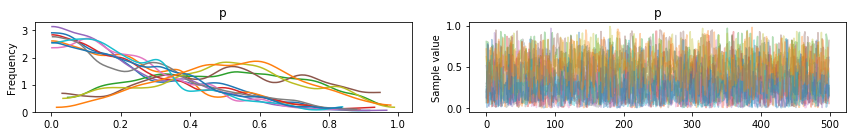

In [113]:
pm.traceplot(recreate_issue_trace)

In [114]:
toy_dataset.shape

(1,)

TODO:

- take into account age / reproductive_activeness
- use old posteriors as new priors for individual updating

In [198]:
def from_posterior(param, samples):
    """ See https://docs.pymc.io/notebooks/updating_priors.html """
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    
    # maybe we'll need to make sure that x is bounded between 0 and 1
    
    # min_explore_x = x[0] - 3 * width
    # max_explore_x = x[-1] + 3 * width
    
    # x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    widener = 0.1
    x = np.concatenate([[x[0] - widener], x, [x[-1] + widener]])
    y = np.concatenate([[0], y, [0]])
    
    return pm.distributions.Interpolated(param, x, y)



In [199]:
# samples = np.random.beta(a=1, b=1, size=100000)
# x, y = from_posterior('abc', samples)
# pd.DataFrame({'x': x, 'y': y}).plot.scatter(x='x', y='y')

In [200]:
from IPython.core.debugger import set_trace

### process_individual

In [201]:
cleaned_matrix.index[0]

'H002-3229'

In [202]:
def first_sighting(year, indiv_id, indiv_data):
    indiv_years_prior_to = indiv_data[years_prior_to(int(year), indiv_data.index)]
    prior_sightings = np.where(indiv_years_prior_to >= 1)[0]
    
    if prior_sightings.any():
        return int(indiv_years_prior_to.index[prior_sightings[0]])
    else:
        return None


In [203]:
def age_now(proba_age_year_before):
    return proba_age_year_before + 1

In [204]:
def proba_alive(proba_alive_before, proba_alive_this_year):
    return proba_alive_this_year * alive_before 

In [205]:
def save_model(model, trace, index, indiv_id):
    with open('data/model_' + str(index) + '_' + indiv_id + '.pkl', 'wb') as buff:
        pickle.dump({'model': indiv_model, 'trace': trace}, buff)

In [206]:
colors = [
    '#e6194B',
    '#f58231',
    '#ffe119',
    '#bfef45',
    '#3cb44b',
    '#42d4f4',
    '#4363d8',
    '#911eb4',
    '#f032e6',
    '#a9a9a9',
    '#fabebe',
    '#ffd8b1',
    '#fffac8',
    '#aaffc3',
    '#e6beff',
    '#800000'
]

### name

In [207]:
def name(var, year, indiv=None):
    if indiv == None:
        return var + '_' + str(year)
    else:
        return var + '_' + str(year) + '_' + indiv

### age

In [208]:
def age(year, age_last_year, i):
    args = {
        'name': name('age', year, i),
        'var': age_last_year + 1
    }

    return pm.Deterministic(**args)

### alive_observed(obs, data, year, i)

In [209]:
def alive_observed(obs, data, year):
    """
        obs: observation for the year
        data: observations for an individual over the years,
        year: year of interest
    """
    
    if obs >= 1:
        return 1
    elif (
        (data.loc[years_prior_to(year, data.index)].sum() > 0) and \
        (data.loc[years_subsequent_to(year, data.index)].sum() > 0)
    ):
        return 1
    else:
        return 0

### alive

In [210]:
def alive(year, obs, data, alive_last_year, age, beta, negative_alpha, i):
    """
        Assumptions:
            Whale can't be alive if age is less than 0.
            If whale was alive last year, whale has a chance of being alive this year.
            When a whale dies, a whale stays dead (i.e. age_gt_than_0 is true, but alive_last_year is false).
        
        Parameters:
            year: string.
                The year of interest.
                
            obs: integer.
                0 if no female was observed.
                1 if female was observed.
                2 if female and calf were observed.
                
            data: pd.Series
                Observations over the years for the individual whale in question.
                
            alive_last_year: theano.tensor
                Was whale alive the year before the year of interest?
                
            age: theano.tensor
                The age of the whale. Can be negative.
                
            beta: theano.tensor
                When whale can be alive, this is the contributing factor.
                
            negative_alpha: theano.tensor
                A low value that stands for no chance of being alive. Note: We're using approximations of a 
                switch function to speed up computation with NUTS.
                
        Return:
        
            proba_alive: probability of being alive,
            
            alive: Is whale alive / not alive
    """

    age_is_0 = pm.math.ge(age, 0) * pm.math.lt(age, 1) * 1
    
    age_gt_than_0 = pm.math.ge(age, 1) * 1
    
    proba_alive = pm.math.sigmoid(
        beta * (age_gt_than_0 * alive_last_year + age_is_0) + \
        negative_alpha
    )
    
    alive_args = {
        'name': 'alive_' + year + '_' + i, 
        'p': proba_alive,
    }

    observed = alive_observed(obs, data, year)

    if observed:
        alive_args['observed'] = 1
    
    return proba_alive, pm.Bernoulli(**alive_args)

### proba_alive

In [211]:
def proba_alive(beta, age_gt_than_0, alive_last_year, age_is_0, negative_alpha):
    return logistic(beta * (age_gt_than_0 * alive_last_year + age_is_0) + negative_alpha)

### repro_active

In [212]:
def repro_active(year, alive, age, i):
    return pm.Deterministic(
        name('repro_active', year, i),
        pm.math.gt(age, 9) * alive
    ) * 1

### birth

In [213]:
def birth(year, obs, repro_active, birth_last_year, beta, negative_alpha, i):
    """
        Parameters:
            year: string

            repro_active: 
                is whale reproductively active.

            beta: coefficient associated with the probability of giving birth. Only applies when
                there was no birth last year.

            birth_last_year:
                did whale give birth last year
                
        Returns:
            probability of birth
            instance of birth
    """
    
    birth_args = {
        'name': name('birth', year, i),
        'p': pm.math.sigmoid((1-birth_last_year) * (repro_active * beta) + negative_alpha)
    }
    
    if obs == 2:
        birth_args['observed'] = 1
    elif obs == 1:
        birth_args['observed'] = 0
    # elif obs_last_year == 2:
    #   birth_args['observed'] = 0
    
    
    return birth_args['p'], pm.Bernoulli(**birth_args)

### detect

In [214]:
def detect(year, obs, alive, beta, negative_alpha, i):
    p = pm.math.sigmoid(
        beta * alive + negative_alpha
    )
    
    args = {
        'name': name('detect', year, i),
        'p': p
    }
    
    if obs >= 1:
        args['observed'] = 1
    else:
        args['observed'] = 0
        
    return p, pm.Bernoulli(**args)

### process_individual

In [215]:
def process_individual(i, year_i, study_year_data, data, p, obs):
    """
        i: the index for an individual.
        year_i: index associated to a year.
        study_year_data: individual data restricted to the study years.
        data: individual data.
        p: dict. Where variables are stored.
        obs: observation for a given year.
    """
    year = study_year_data.index[year_i]
    last_year = str(int(year) - 1)

    p[name('age', year, i)] = age(year, p[name('age', last_year, i)], i)

    p[name('proba_alive', year, i)], p[name('alive', year, i)] = alive(
        year=year, 
        obs=obs,
        data=data,
        alive_last_year=p[name('alive', last_year, i)],
        age=p[name('age', year, i)],
        beta=p['beta_alive'],
        negative_alpha=p['negative_alpha'],
        i=i
    )

    p[name('repro_active', year, i)] = repro_active(
        year=year,
        alive=p[name('alive', year, i)],
        age=p[name('age', year, i)],
        i=i
    )

    p[name('proba_birth', year, i)], p[name('birth', year, i)] = birth(
        year=year,
        obs=obs,
        repro_active=p[name('repro_active', year, i)],
        birth_last_year=p[name('birth', last_year, i)],
        beta=p[name('beta_birth', year)],
        negative_alpha=p['negative_alpha'],
        i=i
    )

    p[name('proba_detect', year, i)], p[name('detect', year, i)] = detect(
        year=year,
        obs=obs,
        alive=p[name('alive', year, i)],
        beta=p['beta_detect'],
        negative_alpha=p['negative_alpha'],
        i=i
    )

    p1 = p[name('proba_alive', year, i)] * (1 - p[name('proba_birth', year, i)]) * p[name('proba_detect', year, i)]

    p2 = p[name('proba_alive', year, i)] * p[name('proba_birth', year, i)] * p[name('proba_detect', year, i)]

    p0 = 1 - p1 - p2

    pm.Categorical(
        name('obs', year, i),
        p=[
            p0,
            p1,
            p2
        ],
        observed=obs
    )


In [216]:
cleaned_matrix.shape[0]

115

### process_padding_year

In [217]:
known_birth_years

{'H009-1419': 1982,
 'H065-7002': 1985,
 'H067-7014': 1988,
 'H169-7029': 1990,
 'H456-nan': 1994,
 'H464-nan': 1996,
 'H473-7092': 1997,
 'H479-7094': 1997,
 'H483-7096': 1997,
 'H549-nan': 2001,
 'H551-nan': 2000,
 'H565-nan': 2000,
 'H590-nan': 2003,
 'H624-nan': 2005,
 'H626-nan': 2005,
 'H638-nan': 2005,
 'H647-nan': 2005}

In [218]:
def process_padding_year(padding_year, indiv, data):

    p[name('proba_alive', str(padding_year), indiv)] = pm.Beta(name('proba_alive', str(padding_year), indiv), alpha=1, beta=1)
    p[name('proba_birth', str(padding_year), indiv)] = pm.Beta(name('proba_birth', str(padding_year), indiv), alpha=1, beta=1)


    # TODO: set observables for age_2004
    # p[name('age', str(padding_year), indiv)] = pm.Uniform(name('age', str(padding_year), indiv), lower=8, upper=40)
    p[name('age', str(padding_year), indiv)] = get_age(padding_year, indiv, known_birth_years, data)
    # alive_2004
    alive_2004_args = {
        'name': name('alive', padding_year, indiv), 
        'p': p[name('proba_alive', str(padding_year), indiv)]
    }

    observed_alive_2004 = alive_observed(
        obs=data.loc[padding_year],
        data=data,
        year=padding_year
    )

    if observed_alive_2004:
        alive_2004_args['observed'] = 1

    p[name('alive', str(padding_year), indiv)] = pm.Bernoulli(
        **alive_2004_args
    )

    # birth_2004
    birth_2004_args = {
        'name': name('birth', str(padding_year), indiv),
        'p': p[name('proba_birth', str(padding_year), indiv)]
    }

    if data.loc[padding_year] == 2:
        birth_2004_args['observed'] = 1
    elif data.loc[padding_year] == 1:
        birth_2004_args['observed'] = 0

    p[name('birth', str(padding_year), indiv)] = pm.Bernoulli(**birth_2004_args)

In [219]:
cleaned_matrix.index

Index(['H002-3229', 'H004-1422', 'H008-1417', 'H009-1419', 'H035-2088',
       'H042-1451', 'H044-1424', 'H065-7002', 'H067-7014', 'H102-nan',
       ...
       'H738-nan', 'H745-nan', 'H747-nan', 'H748-nan', 'H752-nan', 'H753-nan',
       'H782-nan', 'H788-nan', 'H798-nan', 'nan-new cow 2016'],
      dtype='object', length=115)

In [221]:

with pm.Model() as test_model:
    
    p = {}
    
    # p['negative_alpha'] = pm.Normal('negative_alpha', mu=-10, sd=0.5)
    p['negative_alpha'] = pm.Constant('negative_alpha', c=-10)
    
    # Associated to the probability of being alive, given age is greater than 0
    p['beta_alive'] = pm.Normal('beta_alive', mu=10, sd=1)
    p['beta_detect'] = pm.Normal('beta_detect', mu=10, sd=1)
    
    for year in range(2005, 2017):
        # If whale can give birth, this is the coefficient associated to the probability of giving birth.
        p[name('beta_birth', year)] = pm.Normal(name('beta_birth', year), mu=10, sd=1)

    
    
    padding_year = '2004'
    
    ############################################
    
    indiv_index = 0
    indiv = cleaned_matrix.index[indiv_index]
    data = cleaned_matrix.iloc[indiv_index]
    study_year_data = data.loc[STUDY_YEAR_COLUMNS]
    
    ############################################
    
    process_padding_year(padding_year, indiv, data)

    for year_i, obs in enumerate(study_year_data):
        process_individual(indiv, year_i, study_year_data, data, p, obs)
        
    trace = pm.sample(draws=1000, tune=3000)
    


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [negative_alpha]
>NUTS: [age_2004_H002-3229, proba_birth_2004_H002-3229, proba_alive_2004_H002-3229, beta_birth_2016, beta_birth_2015, beta_birth_2014, beta_birth_2013, beta_birth_2012, beta_birth_2011, beta_birth_2010, beta_birth_2009, beta_birth_2008, beta_birth_2007, beta_birth_2006, beta_birth_2005, beta_detect, beta_alive]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:44<00:00, 357.78draws/s]


GridSpec(1, 2, width_ratios=[3, 1])

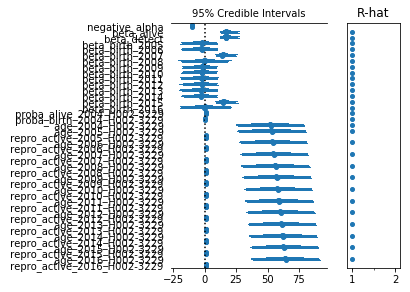

In [222]:
pm.forestplot(trace)

In [223]:
traces = [trace]

In [224]:
traces

[<MultiTrace: 4 chains, 1000 iterations, 45 variables>]

In [225]:
cleaned_matrix.loc['H009-1419']

1980    0
1981    0
1982    1
1983    0
1984    0
1985    0
1986    0
1987    1
1988    1
1989    1
1990    1
1991    2
1992    1
1993    1
1994    2
1995    1
1996    1
1997    2
1998    1
1999    1
2000    1
2001    2
2002    1
2003    2
2004    1
2005    2
2006    1
2007    1
2008    2
2009    1
2010    1
2011    1
2012    1
2013    1
2014    1
2015    2
2016    1
Name: H009-1419, dtype: int64

In [226]:
for indiv_index in range(1, cleaned_matrix.shape[0]):
    test_model = pm.Model()
    with test_model:

        p = {}

        # p['negative_alpha'] = pm.Normal('negative_alpha', mu=-10, sd=0.5)
        p['negative_alpha'] = pm.Constant('negative_alpha', c=-10)

        # Associated to the probability of being alive, given age is greater than 0
        p['beta_alive'] = from_posterior('beta_alive', trace['beta_alive'])

        # Given that whale is alive and has already been introduced, this is associated with the rate
        # of detection for a given year
        p['beta_detect'] = from_posterior('beta_detect', trace['beta_detect'])
        
        for year in range(2005, 2017):
            # If whale can give birth, this is the coefficient associated to the probability of giving birth.
            p[name('beta_birth', year)] = from_posterior(name('beta_birth', year), trace[name('beta_birth', year)])


        padding_year = '2004'

        ############################################

        indiv = cleaned_matrix.index[indiv_index]
        data = cleaned_matrix.iloc[indiv_index]
        study_year_data = data.loc[STUDY_YEAR_COLUMNS]

        ############################################

        process_padding_year(padding_year, indiv, data)

        for year_i, obs in enumerate(study_year_data):
            process_individual(indiv, year_i, study_year_data, data, p, obs)

        trace = pm.sample(draws=1000, tune=1000)
        traces.append(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [negative_alpha]
>NUTS: [age_2004_H004-1422, proba_birth_2004_H004-1422, proba_alive_2004_H004-1422, beta_birth_2016, beta_birth_2015, beta_birth_2014, beta_birth_2013, beta_birth_2012, beta_birth_2011, beta_birth_2010, beta_birth_2009, beta_birth_2008, beta_birth_2007, beta_birth_2006, beta_birth_2005, beta_detect, beta_alive]
>BinaryGibbsMetropolis: [birth_2007_H004-1422, birth_2008_H004-1422, alive_2011_H004-1422, birth_2011_H004-1422, alive_2012_H004-1422, birth_2012_H004-1422, alive_2013_H004-1422, birth_2013_H004-1422, alive_2014_H004-1422, birth_2014_H004-1422, alive_2015_H004-1422, birth_2015_H004-1422, alive_2016_H004-1422, birth_2016_H004-1422]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:47<00:00, 168.02draws/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [negative_alpha]
>NUTS: [age_2004_H008-1417, proba_birth_2004_H008-1417, proba_alive_2004_H008-1417, beta_birth_2016, beta_b

## Results

GridSpec(1, 2, width_ratios=[3, 1])

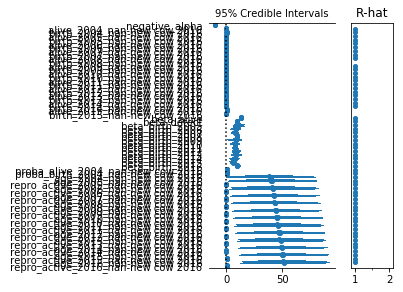

In [227]:
pm.forestplot(trace)

GridSpec(1, 2, width_ratios=[3, 1])

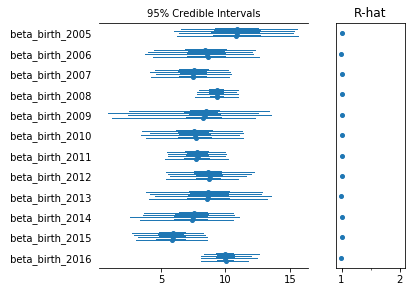

In [228]:
pm.forestplot(trace, varnames=['beta_birth_' + str(year) for year in range(2005,2017)])

In [ ]:
# TODO: Convert birth beta to probabilities
# (1-birth_last_year) * (repro_active * beta) + negative_alpha)

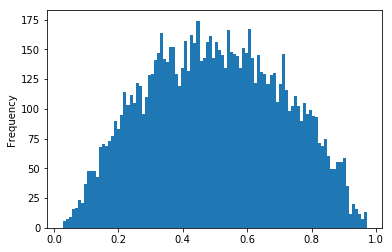

In [240]:
pd.Series(logistic(np.random.normal(0,1, size=10000))).plot.hist(bins=100)

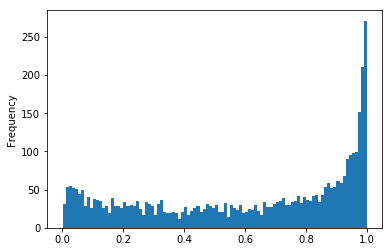

In [236]:
pd.Series(logistic(trace['beta_birth_2005'] - 10)).plot.hist(bins=100)

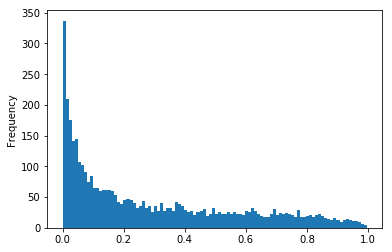

In [232]:
pd.Series(logistic(trace['beta_birth_2006'] - 10)).plot.hist(bins=100)

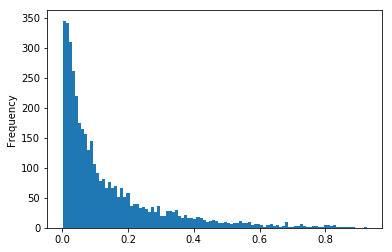

In [233]:
pd.Series(logistic(trace['beta_birth_2007'] - 10)).plot.hist(bins=100)

In [191]:
traces

[<MultiTrace: 4 chains, 1000 iterations, 59 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 73 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 60 variables>]

GridSpec(1, 2, width_ratios=[3, 1])

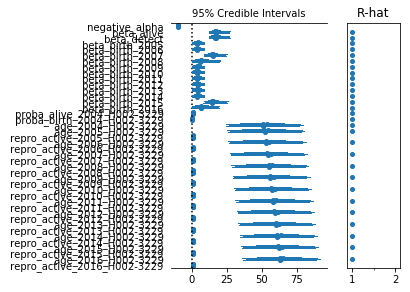

In [193]:
pm.forestplot(traces[0])

GridSpec(1, 2, width_ratios=[3, 1])

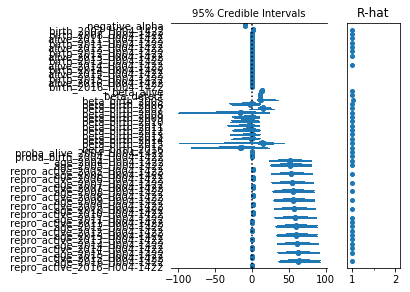

In [194]:
pm.forestplot(traces[1])

GridSpec(1, 2, width_ratios=[3, 1])

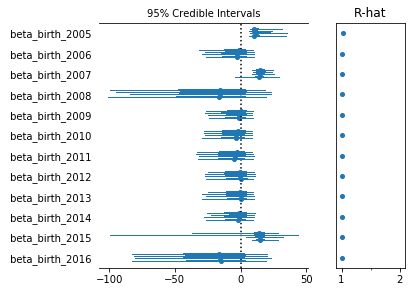

In [197]:
pm.forestplot(traces[1], varnames=['beta_birth_' + str(year) for year in range(2005,2017)])

GridSpec(1, 2, width_ratios=[3, 1])

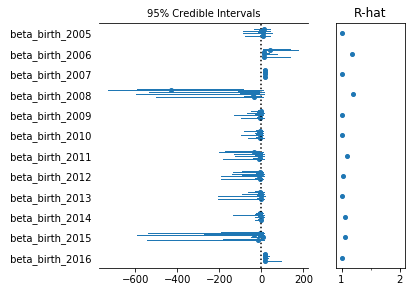

In [196]:
pm.forestplot(traces[2], varnames=['beta_birth_' + str(year) for year in range(2005,2017)])

In [192]:
trace

<MultiTrace: 4 chains, 1000 iterations, 60 variables>

GridSpec(1, 2, width_ratios=[3, 1])

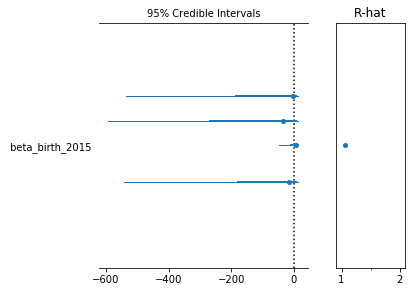

In [189]:
pm.forestplot(trace, varnames=['beta_birth_2015'])

In [77]:
# fig, ax = plt.subplots(figsize=(8, 6))

def plot(var, trace, ax):
    t_plot = STUDY_YEAR_COLUMNS
    
    lows = []
    highs = []
    means = []
    
    for year in range(2005, 2017):
        trace_of_interest = trace[name(var, year)]
        low, high = np.percentile(trace_of_interest, [2.5, 97.5])
        
        lows.append(low)
        highs.append(high)
        means.append(trace_of_interest.mean())
                
    ax.plot(
        t_plot, means,
        label="Posterior expected value",
        marker='o'
    );
    
    ax.fill_between(
        t_plot, lows, highs,
        alpha=0.5, label="95% interval"
    );

    ax.set_xlim(0, len(STUDY_YEAR_COLUMNS) - 1);
    ax.set_ylim(-5, 35);
    ax.set_xlabel("year");

    # ax.yaxis.set_major_formatter(PCT_FORMATTER);
    ax.set_ylabel(var);
    ax.set_title(var)
    ax.legend(loc=2);

In [78]:
# beta_detect, beta_alive, beta_birth, beta_intro

def plot_trace(trace, min_xlim=-5, max_xlim=60):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
    
    plot('beta_alive', trace, ax[0,0])
    plot('beta_introduce', trace, ax[0,1])
    plot('beta_birth', trace, ax[1,0])
    plot('beta_detect', trace, ax[1,1])
    
    plt.tight_layout()

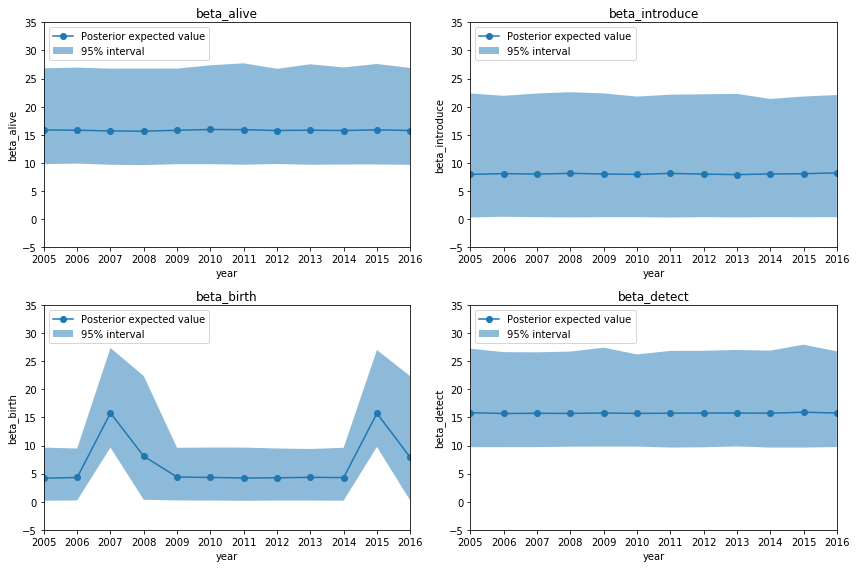

In [79]:
plot_trace(trace)

GridSpec(1, 2, width_ratios=[3, 1])

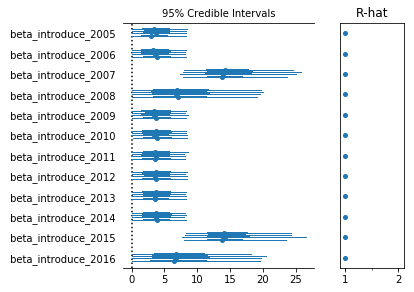

In [403]:
pm.forestplot(trace, varnames=[name('beta_introduce', year) for year in range(2005, 2017)])

In [401]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
negative_alpha,-9.158210,0.494137,0.009040,-10.146177,-8.212811,3007.206435,1.000143
beta_already_introduced,17.364045,4.206596,0.079806,11.292429,25.928885,2473.522835,0.999677
beta_alive_2005,15.023060,4.562281,0.087846,8.129192,24.465116,2752.650273,0.999622
beta_introduce_2005,3.822970,2.514211,0.050683,0.000527,8.360814,2151.510081,1.001519
beta_birth_2005,7.904195,6.037239,0.103775,0.003121,19.565136,3422.765989,0.999555
beta_detect_2005,15.037685,4.712105,0.084644,7.848395,24.632450,3492.643104,0.999739
beta_alive_2006,15.170650,4.658216,0.085449,7.917598,24.415369,3307.790440,0.999981
beta_introduce_2006,3.800829,2.516056,0.052486,0.002262,8.203446,1982.815123,1.001246
beta_birth_2006,8.127382,6.085882,0.092365,0.018379,19.883237,4008.865949,1.000099
beta_detect_2006,15.201092,4.706375,0.083969,7.763140,24.854221,3292.451689,1.000240


In [ ]:
observations = pd.Series({'2005': 1, '2006': 2, '2007': 0})
num_years = 2
with pm.Model() as test_model:
    p = {}

    p['negative_alpha'] = pm.Normal('negative_alpha', mu=-10, sd=0.5)
    p['age'] = pm.Uniform('age')
   
    p['proba_alive'] = pm.Beta('proba_alive', alpha=1, beta=1, shape=num_years)
    p['proba_birth'] = pm.Beta('proba_birth', alpha=1, beta=1, shape=num_years)
    p['beta_alive_for_detect'] = pm.Normal('beta_alive_for_detect', mu=0, sd=10, shape=2)
    
    for i, obs in enumerate(observations):
        year = obs.index[i]


        p['age_' + year] = pm.Uniform('age_' + year, lower=9, upper=80)
        

        p['alive_' + year] = alive(year, obs, p['proba_alive'][i])

        # TODO: whale needs to be alive to be reproductively active
        p['proba_repro_active_' + year] = pm.math.sigmoid(p['age_' + year] - 9)
        p['repro_active_' + year] = pm.Bernoulli('proba_repro_active_' + year, p=p['proba_repro_active_' + year], observed=1)

        p['birth_' + year] = pm.Bernoulli('birth_' + year, p=p['proba_birth'][i], observed=0)

        p['proba_detect_' + year] = pm.math.sigmoid(
            p['beta_alive_for_detect'][i] * p['alive_' + year] + p['negative_alpha']
        )

        p['detect_' + year] = pm.Bernoulli('detect_' + year, p=p['proba_detect_' + year], observed=1)

        p1 = p['proba_alive'][i] * (1 - p['proba_birth'][i]) * p['proba_detect_' + year]
        p2 = p['proba_alive'][i] * p['proba_birth'][i] * p['proba_detect_' + year]
        p0 = 1 - p1 - p2

        pm.Categorical(
            'obs_' + year,
            p=[
                p0,
                p1,
                p2
            ],
            observed=[1]
        )
    
#     i = 1
#     year = obs.index[i]
    
#     p['alive_' + year] = pm.Bernoulli('alive_' + year, p=p['proba_alive'][i], observed=1)
#     p['age_' + year] = p['age_' + str(int(year) - 1)] + 1
#     p['proba_repro_active_' + year] = pm.math.sigmoid(p['age_' + year] - 9)
#     p['repro_active_' + year] = pm.Bernoulli('proba_repro_active_' + year, p=p['proba_repro_active_' + year], observed=1)
#     p['birth_' + year] = pm.Bernoulli('birth_' + year, p=p['proba_birth'][i], observed=1)
    
#     p['proba_detect_' + year] = pm.math.sigmoid(
#         p['beta_alive_for_detect'][i] * p['alive_' + year] + p['negative_alpha']
#     )
#     p['detect_' + year] = pm.Bernoulli('detect_' + year, p=p['proba_detect_' + year], observed=1)
    
#     p1 = p['proba_alive'][i] * (1 - p['proba_birth'][i]) * p['proba_detect_' + year]
#     p2 = p['proba_alive'][i] * p['proba_birth'][i] * p['proba_detect_' + year]
#     p0 = 1 - p1 - p2
    
#     pm.Categorical(
#         'obs_' + year,
#         p=[
#             p0,
#             p1,
#             p2
#         ],
#         observed=[2]
#     )
    
    
    trace = pm.sample()
    

GridSpec(1, 2, width_ratios=[3, 1])

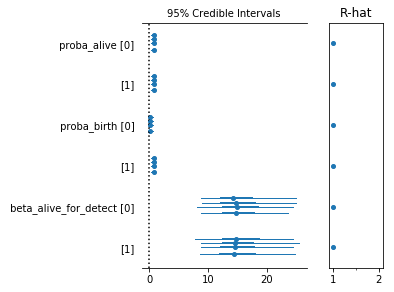

In [214]:
pm.forestplot(trace, varnames=['proba_alive', 'proba_birth', 'beta_alive_for_detect'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e29bd7320>,
      dtype=object)

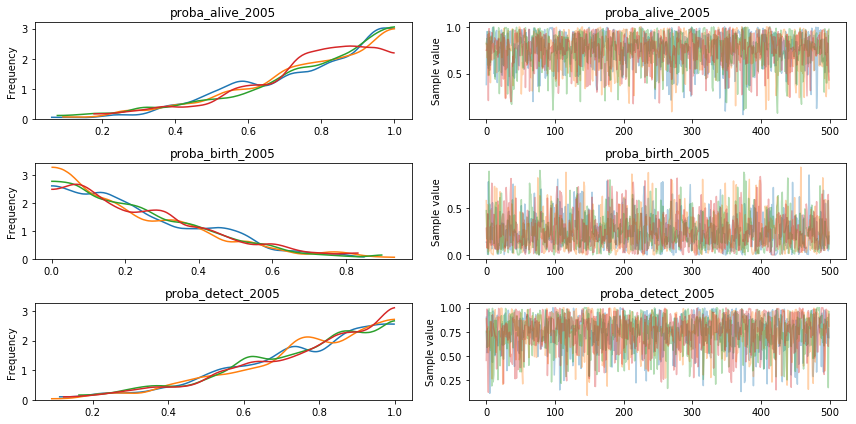

In [197]:
pm.traceplot(trace, varnames=['proba_alive_2005', 'proba_birth_2005', 'proba_detect_2005'])

In [189]:
def process_individual(p, indiv_data, study_year_columns, indiv_id):
    """
        p: dict.
            Stores parameters.
    """

    study_data = indiv_data[study_year_columns]
    

    
    indices = study_data.index
    
    p['zero'] = pm.Constant('zero', c=0)
    p['one'] = pm.Constant('one', c=1)
    
    for i, obs in enumerate(study_data.iloc[:1]):
        # this thing circles back. incorrect code
        last_year = indices[i-1]
        year = indices[i]
        
        set_trace()
        # generate age
        p['age_' + str(year)] = p['age_' + str(last_year)] + 1
        
        # generate alive
        if i == 0:
            proba_alive = p['proba_alive_' + str(year)] * pm.math.gt(p['age_' + str(this_year)], 0)
        else:
            proba_alive = pm.math.switch(
                pm.math.eq(p['alive_' + str(last_year)], 1),
                p['proba_alive_' + str(year)],
                p['zero']
            )

        alive_args = {
            'name': 'alive_' + str(year),
            'p': proba_alive,
        }
        
        if obs > 0 or \
            (
                (indiv_data[years_prior_to(int(year), indiv_data.index)].sum() > 0) and \
                (indiv_data[years_subsequent_to(int(year), indiv_data.index)].sum() > 0)
            ):
                
            alive_args['observed'] = 1

        p['alive_' + str(year)] = pm.Bernoulli(**alive_args)
        
        # generate repro_active
        
        proba_repro_name = 'proba_repro_active_' + str(year)
        
        proba_repro_active_args = {
            'name': proba_repro_name,
            'alpha': 1.0,
            'beta': 1.0

        }
        
        # if whale gave birth in the past, then whale must be repro_active
        # if we observe that the earliest observed sighting was more than 9 years ago,
        # then whale is repro_active
        
        first_sighting_indiv = first_sighting(int(year), indiv_id, indiv_data)
        
        if (indiv_data[years_prior_to(int(year), indiv_data.index)] == 2).sum() > 0:
            proba_repro_active_args['observed'] = 1
        elif first_sighting_indiv != None and int(year) - first_sighting_indiv > 9:
            proba_repro_active_args['observed'] = 1
             
        # set the probability of being repr_active

        p['repro_active_' + str(year)] = \
            p['alive_' + str(year)] * p['repro_active_' + str(last_year)] * \
            p['age_' + str(year) + '_' + indiv_id]
        
        p[proba_repro_active_args['name']] = pm.Beta('')

        # so there's a beta and an alpha. Each year the beta and alpha would be different?

        repr_active_args = {
            'name': 'repro_active_' + str(year),
            'p': pm.Beta(**proba_repro_active_args),
        }
        
        p['repro_active_' + str(year)] = pm.Bernoulli(**repr_active_args)
        
        # generate detect

        p['detect_' + str(year)] = pm.Bernoulli(
            'detect_' + str(year),
            p=p['proba_detection_' + str(year)] * p['alive_' + str(year)],
            observed=int(obs>0)
        )

        # generate birth

        birth_args = {
            'name': 'birth_' + str(year),
            'p': pm.math.switch(
                p['repro_active_' + str(year)] * p['alive_' + str(year)],
                p['proba_birth_' + str(year)],
                p['zero']
            )
        }

        if obs == 2:
            birth_args['observed'] = 1
        elif obs == 1 or indiv_data[last_year] == 2:
            birth_args['observed'] = 0

        p['birth_' + str(indices[i])] = pm.Bernoulli(**birth_args)

        # observations

        obs_0 = pm.math.or_(pm.math.eq(p['alive_' + str(year)], 0), pm.math.eq(p['detect_' + str(year)], 0))
        obs_1 = p['alive_' + str(year)] * p['detect_' + str(year)] * pm.math.eq(p['birth_' + str(year)], 0)
        obs_2 = 1 - obs_0 - obs_1

        pm.Categorical(
            'observed_counts_' + str(year),
            p=tt.stack(
                [
                    pm.math.sigmoid(obs_0 * 1000 - 500),
                    pm.math.sigmoid(obs_1 * 1000 - 500),
                    pm.math.sigmoid(obs_2 * 1000 - 500)
                ],
                axis=0
            ),
            observed=obs
        )


In [190]:
index = 0
indiv_dataset = cleaned_matrix.iloc[index]
indiv_id = cleaned_matrix.index[index]

with pm.Model() as indiv_model:
    p = {
        'age_' + str(int(STUDY_YEAR_COLUMNS[0]) - 1): pm.Uniform('age_' + str(int(STUDY_YEAR_COLUMNS[0]) - 1), -1, 10)
    }

    for i in STUDY_YEAR_COLUMNS:
        p['proba_birth_' + str(i)] = pm.Beta('proba_birth_' + str(i), alpha=1.0, beta=1.0)
        p['proba_detection_' + str(i)] = pm.Beta('proba_detection_' + str(i), alpha=1.0, beta=1.0)
        p['proba_alive_' + str(i)] = pm.Beta('proba_alive_' + str(i), alpha=1.0, beta=1.0)


    process_individual(p, indiv_dataset, STUDY_YEAR_COLUMNS, indiv_id)

    trace = pm.sample()

save_model(
    model=indiv_model,
    trace=trace,
    index=index,
    indiv_id=indiv_id,
)


> <ipython-input-189-a0598dd4ddf2>(22)process_individual()
     20         set_trace()
     21         # generate age
---> 22         p['age_' + str(year)] = p['age_' + str(last_year)] + 1
     23 
     24         # generate alive



ipdb>  year


'2005'


ipdb>  last_year


'2016'


ipdb>  indiv_data


1980    1
1981    0
1982    0
1983    1
1984    1
1985    0
1986    0
1987    1
1988    1
1989    2
1990    0
1991    1
1992    1
1993    2
1994    1
1995    1
1996    1
1997    2
1998    1
1999    1
2000    1
2001    1
2002    1
2003    2
2004    1
2005    1
2006    1
2007    2
2008    1
2009    1
2010    1
2011    1
2012    1
2013    1
2014    1
2015    2
2016    1
Name: H002-3229, dtype: int64


ipdb>  study_data


2005    1
2006    1
2007    2
2008    1
2009    1
2010    1
2011    1
2012    1
2013    1
2014    1
2015    2
2016    1
Name: H002-3229, dtype: int64


ipdb>  exit


BdbQuit: 